In [21]:
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import time

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,KFold,cross_val_score,cross_validate,GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc,roc_curve
from sklearn.feature_selection import SelectFromModel


import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_colwidth',None)

In [22]:
#read in text
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

data = pd.read_csv('SMSSpamCollection.tsv',sep='\t',header=None)
data.columns = ['label','sms_text']
data['label_num']= data['label'].map({'ham': 0,'spam':1})

In [23]:
#create func to remove punctuation, tokenize, remove stopwords,stem

stopword = nltk.corpus.stopwords.words('english')
def clean_text (single_sms):
    #remove punctuation
    new_text = ''.join([char for char in single_sms if char not in string.punctuation])
    #tokenize sentence (will remove extra spaces as well)
    tokens = word_tokenize(new_text.lower())
    #remove stopwords and returned stemmed word
    new_text = [ps.stem(word) for word in tokens if word not in stopword]
    
    return new_text

In [24]:
#feature engineering

#length of text
def ret_len(text):
    return len(text)- text.count(' ')

data ['text_len'] = data['sms_text'].apply(ret_len)
#data.head()

#% of punctuation chars in a text
def ret_punc_per(text):
    punc_count = 0
    for char in text :
        if char in string.punctuation:
            punc_count += 1
            
    return round(punc_count/(len(text)- text.count(' ')),3)*100
data['punct%'] = data['sms_text'].apply(ret_punc_per)
#data.head()

#num of digits in a text
def ret_digit_per(text):
    digit_count = 0
    for char in text :
        if char.isdigit():
            digit_count += 1
            
    return round(digit_count/(len(text)- text.count(' ')),3)*100
data ['digit%'] = data['sms_text'].apply(ret_digit_per)
#data.head() 

#percentage of capital letters:
def ret_upper_per(text):
    upper_count = 0
    for char in text :
        if char.isupper():
            upper_count += 1
            
    return round(upper_count/(len(text)- text.count(' ')),3)*100
data['upper%'] = data['sms_text'].apply(ret_upper_per)
#data.head()

def ret_url_presence(text):
   
    urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)
    if len(urls) == 0:
        #empty list, no url
        return 0
    else :
        return 1 #text has urls
data ['url_present'] = data['sms_text'].apply(ret_url_presence)


In [25]:
#Split data :

X_train, X_test, y_train, y_test = train_test_split(data[['sms_text','text_len','punct%','digit%','upper%','url_present']],data['label_num'],test_size=0.20, random_state=42)



In [26]:
#create vectorised dataset : convert sms_text col to a numeric form

#create vectorizer and pass clean func made above
tfid_vect = TfidfVectorizer(analyzer=clean_text)
tfid_vect_fit = tfid_vect.fit(X_train['sms_text'])

#create vectorised columns
tfid_train = tfid_vect_fit.transform(X_train['sms_text']) #sparse matrix
tfid_test = tfid_vect_fit.transform(X_test['sms_text']) #sparse matrix


new_train_df = X_train[['text_len','punct%','digit%','upper%','url_present']].reset_index(drop = True)
vect_train_df = pd.DataFrame(tfid_train.toarray()) #convert sparse matrix to array
vect_train_df.columns = tfid_vect.get_feature_names_out() #column names will be unique words 

new_test_df = X_test[['text_len','punct%','digit%','upper%','url_present']].reset_index(drop = True)
vect_test_df = pd.DataFrame(tfid_test.toarray()) #convert sparse matrix to array
vect_test_df.columns = tfid_vect.get_feature_names_out() #column names will be unique words 

X_train_vect = pd.concat([new_train_df,vect_train_df],axis=1)
X_test_vect = pd.concat([new_test_df,vect_test_df],axis=1)

In [27]:
X_train_vect.head()

,text_len,punct%,digit%,upper%,url_present,0,008704050406,0089mi,0121,01223585334,...,»,é,ü,üll,–,‘,’,“,…,…thank
0,94,6.4,2.1,3.2,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,104,5.8,1.9,3.8,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,49,6.1,0.0,4.1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,39,2.6,0.0,2.6,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22,4.5,0.0,4.5,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
%%time
#Gradient Boost  : needs balanced data , GB can scale itself
#Create a benchmark for comparing performance

#oversample 
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train_vect,y_train) #7285 cols

#apply model
gb = GradientBoostingClassifier() #default : n_estimators = 100, learning rate = .1, max_depth = 3

scores = cross_val_score(gb,X_resampled,y_resampled,cv = 5)
print(scores) #model is stable

start = time.time()
gb.fit(X_resampled,y_resampled)
end = time.time()
fit_time = end - start

start = time.time()
y_pred = gb.predict(X_test_vect) #7285 cols
end = time.time()
pred_time = end - start

print(f'fit time is {fit_time} and prediction time is {pred_time}')
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(auc(fpr, tpr))

[0.99092677 0.9837978  0.99416721 0.98963059 0.99416342]
fit time is 29.279529809951782 and prediction time is 0.09595894813537598
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.92      0.91      0.92       149

    accuracy                           0.98      1114
   macro avg       0.95      0.95      0.95      1114
weighted avg       0.98      0.98      0.98      1114

[[953  12]
 [ 13 136]]
0.9501582223458637
CPU times: user 2min 18s, sys: 2.54 s, total: 2min 21s
Wall time: 2min 21s


In [40]:
#This will be used as a threshold to select best features
pd.Series(gb.feature_importances_).mean()

0.00013726835964310226

In [29]:
pd.Series(gb.feature_importances_,index = X_train_vect.columns).sort_values(ascending=False).head(10)

digit%         0.787798
text_len       0.077957
upper%         0.033182
mobil          0.015113
url_present    0.013945
repli          0.005865
free           0.004319
ltgt           0.002928
punct%         0.002721
5              0.002270
dtype: float64

<AxesSubplot:>

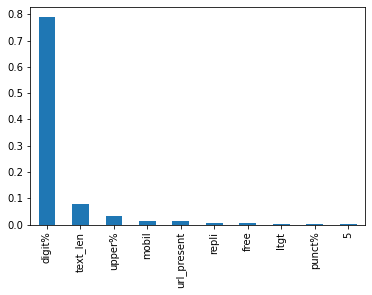

In [30]:

pd.Series(gb.feature_importances_,index = X_train_vect.columns).sort_values(ascending=False).head(10).plot(kind='bar')

In [31]:
#Select best features : Select features whose feature importance is greater than or equal to the mean of feature
#importance of all features.

sel = SelectFromModel(GradientBoostingClassifier()) #n_estimators = 100 is default
sel.fit(X_resampled, y_resampled) #7285 cols

selected_feat = X_resampled.columns[sel.get_support()]

print(len(selected_feat))
print(selected_feat)

87
Index(['text_len', 'punct%', 'digit%', 'upper%', 'url_present', '0anetwork',
       '10am', '2', '30th', '3rd', '4goten', '5', '7', '8', 'adp', 'adrian',
       'adult', 'afraid', 'ami', 'august', 'barbi', 'becom', 'bewar',
       'biggest', 'bluetooth', 'buy', 'cashbincouk', 'chat', 'child', 'club',
       'coincid', 'come', 'content', 'cop', 'dark', 'darl', 'datingi',
       'divorc', 'filthi', 'free', 'freemsgfav', 'gbpsm', 'girl', 'go', 'got',
       'headset', 'hi', 'httpwwwurawinnercom', 'idiot', 'ken', 'link', 'love',
       'ltgt', 'maniac', 'mobil', 'new', 'onto', 'opinion', 'previou', 'rct',
       'repli', 'resent', 'rgd', 'rington', 'scammer', 'sell', 'send',
       'servic', 'sexi', 'sister', 'slower', 'smartthough', 'smile', 'stolen',
       'supplier', 'teenag', 'text', 'thnq', 'toilet', 'tonesrepli', 'top',
       'truli', 'ur', 'week', 'wwwareyouuniquecouk', 'wwwcashbincouk', 'ü'],
      dtype='object')


In [43]:
#Evaluate performance of the model with 87 best features as selected above :

#oversample 
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train_vect[selected_feat],y_train) #87 cols

#apply model
gb = GradientBoostingClassifier() #default : n_estimators = 100, learning rate = .1, max_depth = 3

scores = cross_val_score(gb,X_resampled,y_resampled,cv = 5) #87 cols
print(scores) #model is stable

start = time.time()
gb.fit(X_resampled,y_resampled)
end = time.time()
fit_time = end - start

start = time.time()
y_pred = gb.predict(X_test_vect[selected_feat])
end = time.time()
pred_time = end - start

print(f'Fit time is {fit_time} and Prediction time is {pred_time}')
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(auc(fpr, tpr))

#Accuracy of 7285 cols is same as 87 cols.


[0.99157485 0.98444588 0.99157485 0.98639015 0.99416342]
Fit time is 0.7368929386138916 and Prediction time is 0.0023920536041259766
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.92      0.92      0.92       149

    accuracy                           0.98      1114
   macro avg       0.95      0.95      0.95      1114
weighted avg       0.98      0.98      0.98      1114

[[953  12]
 [ 12 137]]
0.9535139270438502


In [35]:
%%time

#Gridsearch cv : to find best combination of hyperparameters :

gb = GradientBoostingClassifier()
params = {
    'n_estimators':[50,100,150],
    'max_depth':[3,7,11,15],
    'learning_rate':[.01,.10,1]
}

gs = GridSearchCV(gb,params,cv=5) #,n_jobs=-1
y_train_reset_i = y_train.reset_index(drop=True)
gs.fit(X_train_vect[selected_feat],y_train_reset_i) #85 cols

#top 5 models
pd.DataFrame(gs.cv_results_).sort_values('mean_test_score',ascending=False)[:5]

CPU times: user 2min 10s, sys: 155 ms, total: 2min 10s
Wall time: 2min 10s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,0.517216,0.005904,0.002071,0.000045,0.1,3,150,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}",0.985410,0.985410,0.984287,0.985410,0.986517,0.985407,0.000705,1
17,1.128542,0.010313,0.002805,0.000087,0.1,7,150,"{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}",0.982043,0.989899,0.984287,0.987654,0.983146,0.985406,0.002930,2
16,0.753737,0.006045,0.002285,0.000024,0.1,7,100,"{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}",0.979798,0.987654,0.985410,0.987654,0.984270,0.984957,0.002893,3
20,1.709234,0.061518,0.003828,0.000226,0.1,11,150,"{'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 150}",0.983165,0.991021,0.987654,0.976431,0.984270,0.984508,0.004887,4
13,0.345716,0.003852,0.001800,0.000033,0.1,3,100,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}",0.985410,0.984287,0.983165,0.984287,0.984270,0.984284,0.000710,5


In [ ]:
#Best RF model took .3 secs while best GB model took 1.14 secs
#Both use 150 estimators
#for same num of estimators (150) and learning rate (.1), least depth 3 and  had highest accuracy

In [36]:
gs.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}

In [37]:
gs.best_score_

0.9854066255564382

In [44]:
#verify result of gridsearch cv, use best params and features to calculate performance metrics

#oversample 
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train_vect[selected_feat],y_train) #87 cols

#apply model
gb = GradientBoostingClassifier(n_estimators=150,max_depth=3,learning_rate=.1) #best parameters
scores = cross_val_score(gb,X_resampled,y_resampled,cv = 5) #85 cols
print(scores) #model is stable

start = time.time()
gb.fit(X_resampled,y_resampled)
end = time.time()
fit_time = end - start

start = time.time()
y_pred = gb.predict(X_test_vect[selected_feat]) #85 cols
end = time.time()
pred_time = end - start

print(f'Fit time is {fit_time} and Prediction time is {pred_time}')
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(auc(fpr, tpr))

[0.99351912 0.99027868 0.99092677 0.99351912 0.99610895]
Fit time is 1.1064379215240479 and Prediction time is 0.002682924270629883
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.92      0.92      0.92       149

    accuracy                           0.98      1114
   macro avg       0.95      0.95      0.95      1114
weighted avg       0.98      0.98      0.98      1114

[[953  12]
 [ 12 137]]
0.9535139270438502
